In [1]:
import warnings

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.transforms import PositiveDefiniteTransform

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models import GPModel
from pyro.infer import MCMC, HMC, NUTS, Predictive

In [2]:
pyro.set_rng_seed(545711891)
torch.set_default_dtype(torch.float64)

testing = False # TODO: set to False

In [3]:
# Constants
n_train = 20
n_test = 10
N = n_train + n_test
beta = 100
noise = torch.tensor(beta**-1)
X = torch.linspace(0.0, 1.0, N) # grid of observations
x_axis = torch.linspace(0.0, 1.0, 100) # used for graphing

In [4]:
# We choose a periodic kernel,
# as the function we are fitting has periodic tendencies.
def kernel(X, Z, var, length, period):
    d = X.unsqueeze(1).unsqueeze(1) - Z.unsqueeze(1).unsqueeze(0)
    scaled_sin = torch.sin(torch.pi * d / period) / length
    return var * torch.exp(-2 * (scaled_sin**2).sum(-1))

In [5]:
# For the model, we keep the noise a fixed parameter,
# and make all of the other parameters (variance, lengthscale, period) variable.
class Model():
    def __init__(self, noise):
        self.noise = noise

    def __call__(self, X, y=None):
        # As we don't want any of the kernel parameters to be negative,
        # we use lognormal priors.
        var    = pyro.sample("kernel_var",    dist.LogNormal(0.0, 1.0))
        length = pyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
        period = pyro.sample("kernel_period", dist.LogNormal(0.0, 1.0))

        # Compute the covariance with the chosen kernel
        cov = kernel(
            X, X,
            var=var, length=length, period=period
        )
        cov += noise * torch.eye(X.shape[0])

        # Sample predictive values as a gaussian.
        return pyro.sample(
            "y",
            dist.MultivariateNormal(loc=torch.zeros(X.shape[0]), covariance_matrix=cov),
            obs=y,
        )

In [6]:
# Generate Gaussian Process regression model
def gen_model(X, y, noise):
    # We choose a periodic kernel,
    # as the function we are fitting has periodic tendencies.
    k = gp.kernels.Periodic(input_dim=1)
    # As we don't want any of the kernel parameters to be negative,
    # we use a lognormal prior.
    k.variance    = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    k.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    k.period      = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

    return gp.models.GPRegression(X, y, kernel=k, noise=noise)

In [7]:
# Function to learn
def g(x):
    return -(torch.sin(6*torch.pi*x))**2 + 6*x**2 - 5*x**4 + 3.0/2.0 

In [8]:
def sample_data(X, n_train, n_test):
    N = n_train + n_test
    # Partition sample points
    idx = np.random.permutation(N)
    X = X[idx]
    # Sample y_i = g(x_i) + ϵ
    noise = dist.Normal(0.0, beta**-1).sample(sample_shape=(N,))
    y = g(X) + noise
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [9]:
def predict(X, y, X_pred, var, length, period, noise):
    N = X.shape[0]
    eta = (var, length, period)
    # Follow simple GP algorithm from p. 40
    # of Oswin's notes.
    K_S =  kernel(X, X, *eta)
    K_Sx = kernel(X, X_pred, *eta)
    K_xx = kernel(X_pred, X_pred, *eta)
    G = torch.linalg.inv(noise * np.eye(N) + K_S)
    a = torch.matmul(G, y)
    mustar = torch.matmul(K_Sx.T, a)
    Sigmastar = K_xx - torch.matmul(torch.matmul(K_Sx.T, G), K_Sx)
    return mustar, Sigmastar # return mean and covariance matrix

In [10]:
def plot_data(ax, X_train, y_train, X_test, y_test, plot_g=True):
    ax.plot(X_train, y_train, 'kx', label='train')
    ax.plot(X_test, y_test, 'k.', label='test')
    if plot_g:
        ax.plot(x_axis, g(x_axis), 'r-', label='g(x)')
    ax.legend()

In [11]:
def plot_prior_samples(ax, model, n_samples=1):
    N = len(x_axis)
    samples = np.array(
        [model(x_axis).detach().numpy() for _ in range(n_samples)]
    )
    ax.plot(x_axis, samples.T, lw=2)

In [12]:
def plot_predictions(ax, X, mean, cov):
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt().detach().numpy()
    ax.plot(X, mean, "g", lw=2, label="GP prediction")  # plot the mean
    ax.fill_between(
        X,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd),
        (mean + 2.0 * sd),
        color="C0",
        alpha=0.3,
        label="GP uncertainty"
    )
    ax.legend()

In [13]:
def plot_loss(ax, loss):
    ax.plot(loss)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

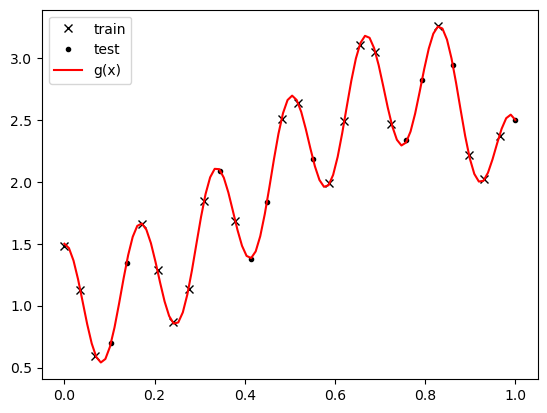

In [14]:
# Sample and plot the data
X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)
fig, ax = plt.subplots()
plot_data(ax, X_train, y_train, X_test, y_test)

# Training via variational inference

In [15]:
# We optimize the following parameters:
# variance, lengthscale, period
params = ("kernel_var", "kernel_length", "kernel_period")
model = Model(noise=noise)

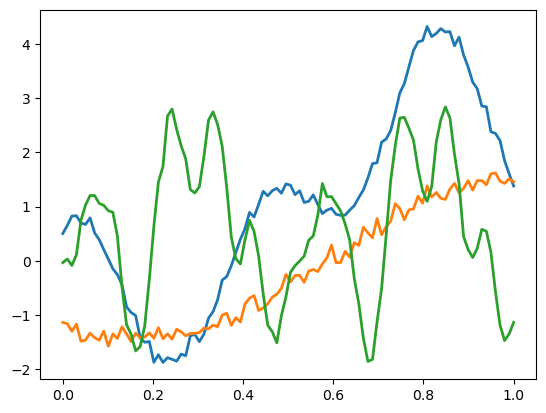

In [16]:
# Samples of unlearned GP
fig, ax = plt.subplots()
plot_prior_samples(ax, model, n_samples=3)

In [17]:
# Compute MAP estimate via gradient descent.
pyro.clear_param_store()

guide=pyro.infer.autoguide.AutoDelta(model)
optim=pyro.optim.Adam({"lr": 0.01})
svi=pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

num_steps = 2000 if not testing else 100
losses = []
for _ in range(num_steps):
    loss = svi.step(X_train, y_train)
    losses.append(loss)

# Extract learned parameters
var, length, period = [pyro.get_param_store()["AutoDelta." + param] for param in params]

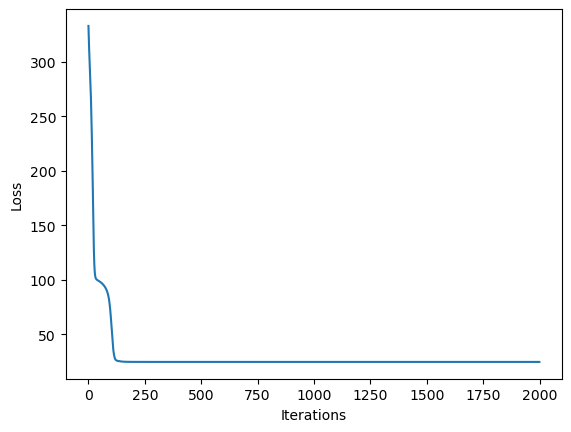

In [18]:
# Plot losses
fig, ax = plt.subplots()
plot_loss(ax, losses)

True


/tmp/ipykernel_36172/322172253.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  G = torch.linalg.inv(noise * np.eye(N) + K_S)


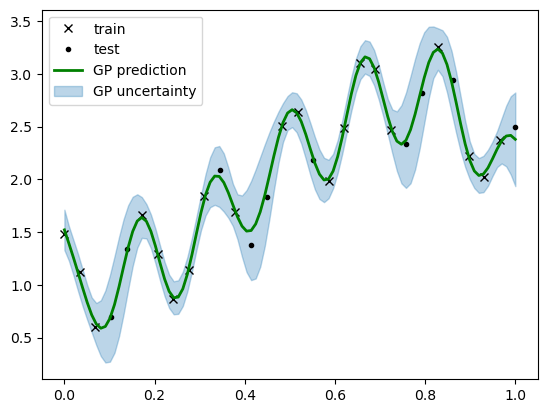

In [19]:
mean_pred, cov_pred = predict(X_train, y_train, x_axis, var, length, period, noise)
print(torch.allclose(cov_pred, cov_pred.T))

fig, ax = plt.subplots()
plot_data(
    ax=ax,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    plot_g=False,
)
plot_predictions(ax=ax, X=x_axis, mean=mean_pred, cov=cov_pred)

In [20]:
# Calculate the log-likelihood of the predictions on the test data
mean_pred, cov_pred = predict(X_train, y_train, X_test, var, length, period, noise)
log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: 9.426456153979448


/tmp/ipykernel_36172/322172253.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  G = torch.linalg.inv(noise * np.eye(N) + K_S)


# Training via MCMC with NUTS

In [21]:
# We optimize the following parameters:
# variance, lengthscale, period
params = ("kernel_var", "kernel_length", "kernel_period")
model = Model(noise=noise)

In [22]:
pyro.clear_param_store()

# Hyper-parameters for learning
warmup_steps = 100 if not testing else 10
num_samples = 100 if not testing else 10
num_chains = 4

nuts_kernel = NUTS(
    model=model,
    jit_compile=True,
)
mcmc = MCMC(
    nuts_kernel,
    num_samples=warmup_steps,
    warmup_steps=num_samples,
    num_chains=num_chains,
)
mcmc.run(X_train, y_train)

/usr/lib/python3.13/site-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=3. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████████████████████████████████| 200/200 [01:29,  2.23it/s, step size=5.58e-02, acc. prob=0.937]                                                                                             


In [23]:
samples = mcmc.get_samples()
posterior_params = [samples[param] for param in params]

/tmp/ipykernel_36172/322172253.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  G = torch.linalg.inv(noise * np.eye(N) + K_S)


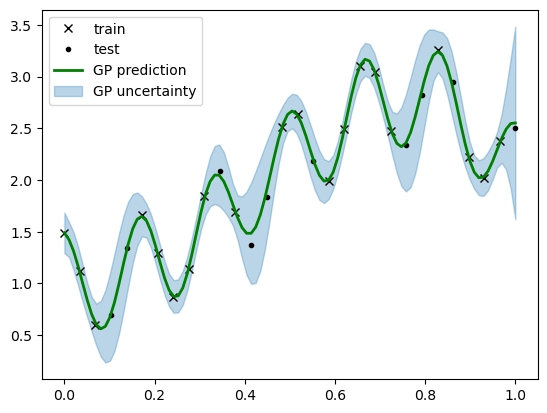

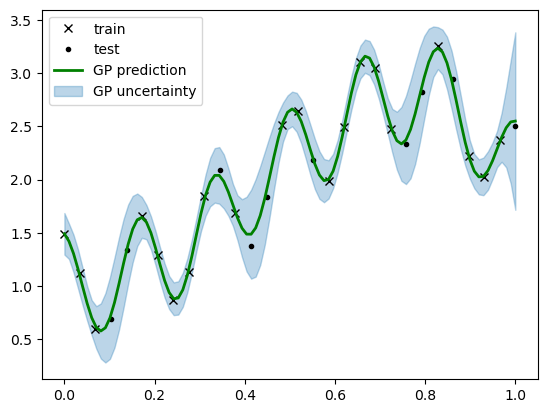

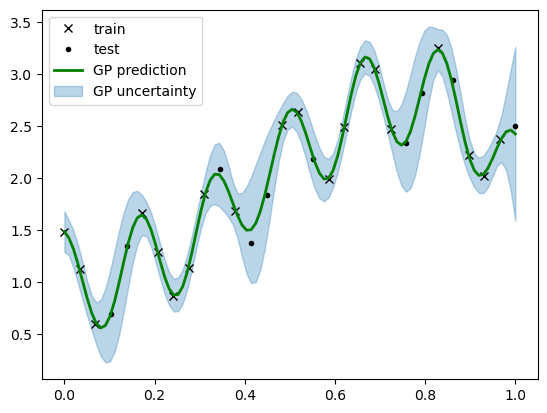

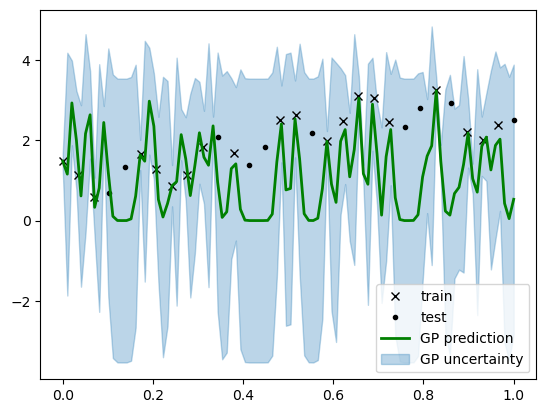

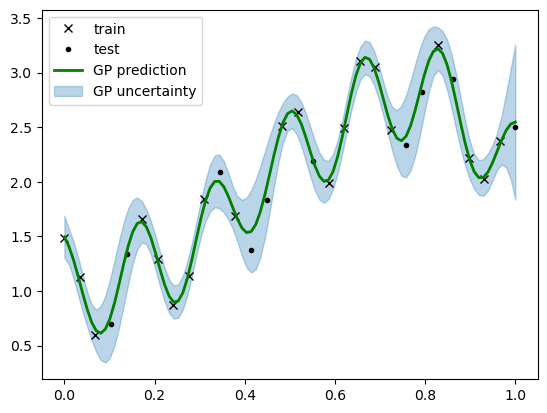

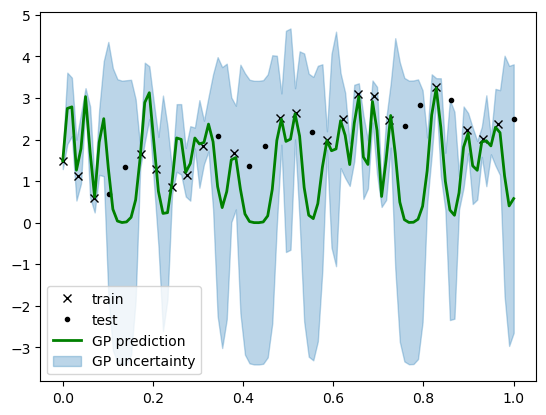

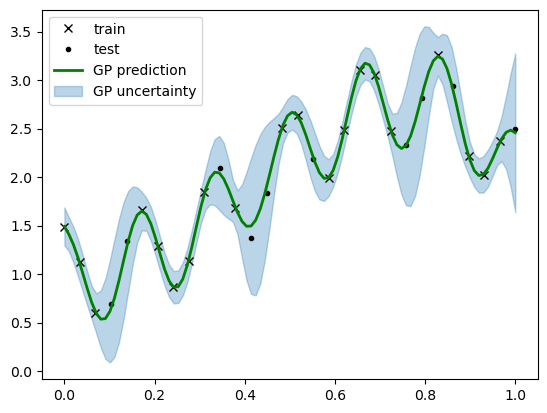

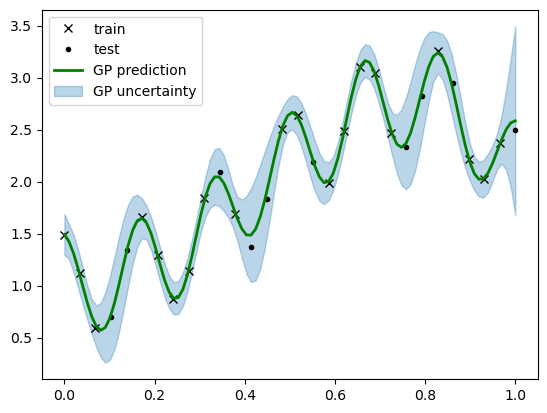

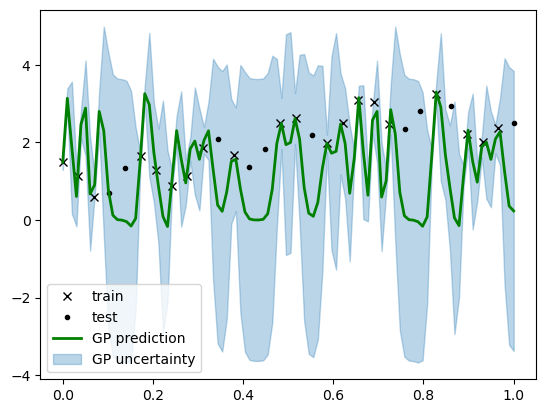

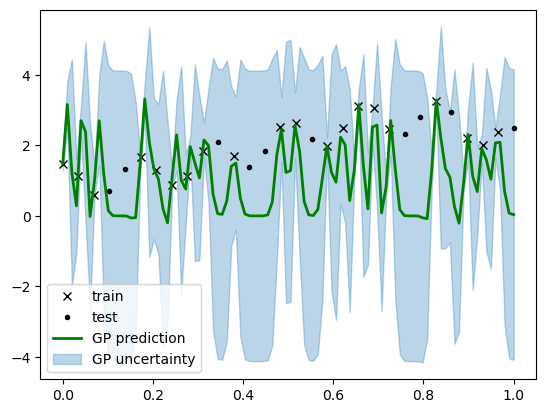

In [24]:
# plot 10 predictions over the x axis
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period: predict(
        X_train, y_train, x_axis, var, length, period, noise
    )
)(*posterior_params)

idx = np.random.randint(0, num_samples*num_chains, 10)
for i in range(10):
    j = idx[i]
    fig, ax = plt.subplots()
    plot_data(
        ax=ax,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        plot_g=False,
    )
    plot_predictions(ax=ax, X=x_axis, mean=mean_preds[j], cov=cov_preds[j])

In [27]:
# Calculate the log-likelihood of the average
# of the sampled predictions on the test data
mean_preds, cov_preds = torch.vmap(
    lambda var, length, period: predict(
        X_train, y_train, X_test, var, length, period, noise
    )
)(*posterior_params)

mean_pred = torch.mean(mean_preds, axis=0)
cov_pred = torch.mean(cov_preds, axis=0)

log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: -9.578406849434066


/tmp/ipykernel_36172/322172253.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  G = torch.linalg.inv(noise * np.eye(N) + K_S)
